In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn.metrics import roc

## Reading data

In [2]:
data = pd.read_csv('data/consolidated_cryptocoin_data.csv')

In [3]:
data

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,ripple,24-Apr-19,0.321114,0.321282,0.296982,0.302318,"1,517,791,002","12,698,877,293"
1,ripple,23-Apr-19,0.323844,0.328396,0.320919,0.321222,"1,077,333,990","13,492,933,875"
2,ripple,22-Apr-19,0.322277,0.329350,0.320237,0.323934,"1,131,094,080","13,606,823,301"
3,ripple,21-Apr-19,0.328678,0.329627,0.318746,0.322449,"1,005,803,846","13,533,407,430"
4,ripple,20-Apr-19,0.331871,0.333213,0.324969,0.328476,"931,570,799","13,786,384,592"
...,...,...,...,...,...,...,...,...
13571,cardano,5-Oct-17,0.021951,0.022154,0.020859,0.021489,"5,562,510","557,139,041"
13572,cardano,4-Oct-17,0.020864,0.022806,0.020864,0.021931,"9,000,050","568,619,548"
13573,cardano,3-Oct-17,0.025757,0.027425,0.020690,0.020816,"16,997,800","539,692,715"
13574,cardano,2-Oct-17,0.024607,0.030088,0.019969,0.025932,"57,641,300","628,899,052"


## Exploratory Data Analysis

In [4]:
data.shape

(13576, 8)

In [5]:
data.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,ripple,24-Apr-19,0.321114,0.321282,0.296982,0.302318,"1,517,791,002","12,698,877,293"
1,ripple,23-Apr-19,0.323844,0.328396,0.320919,0.321222,"1,077,333,990","13,492,933,875"
2,ripple,22-Apr-19,0.322277,0.329350,0.320237,0.323934,"1,131,094,080","13,606,823,301"
3,ripple,21-Apr-19,0.328678,0.329627,0.318746,0.322449,"1,005,803,846","13,533,407,430"
4,ripple,20-Apr-19,0.331871,0.333213,0.324969,0.328476,"931,570,799","13,786,384,592"


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Currency    13576 non-null  object 
 1   Date        13576 non-null  object 
 2   Open        13576 non-null  float64
 3   High        13576 non-null  float64
 4   Low         13576 non-null  float64
 5   Close       13576 non-null  float64
 6   Volume      13576 non-null  object 
 7   Market Cap  13576 non-null  object 
dtypes: float64(4), object(4)
memory usage: 848.6+ KB


In [7]:
data.isnull().sum()

Currency      0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

In [8]:
data['Currency'].unique()

array(['ripple', 'binance-coin', 'eos', 'bitcoin', 'tether',
       'bitcoin-cash', 'stellar', 'litecoin', 'ethereum', 'cardano'],
      dtype=object)

/tmp/ipykernel_22663/1766778262.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

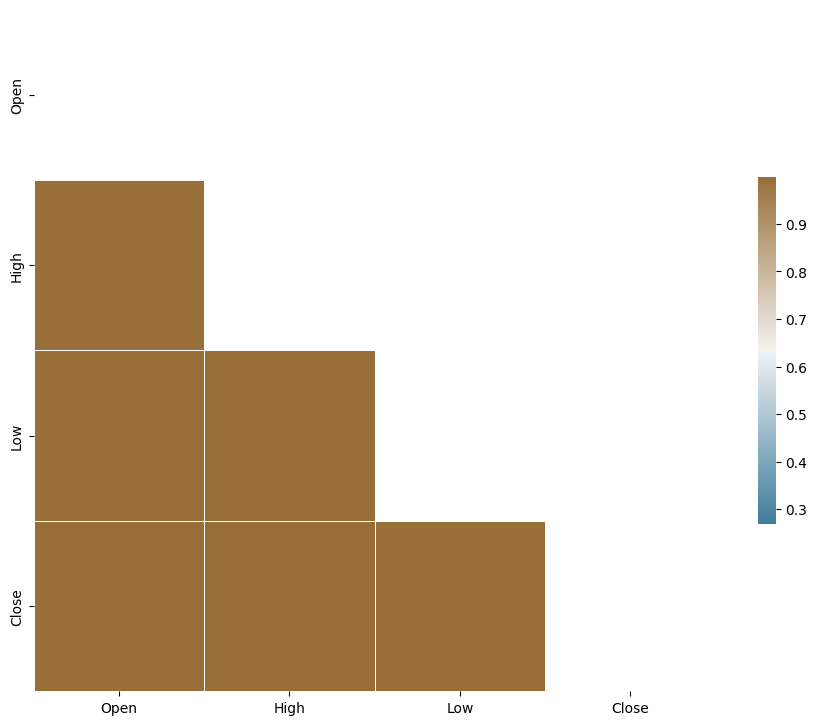

In [9]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 50, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
fig = go.Figure(data=
               [go.Candlestick(x = data['Date'], 
                              open = data['Open'],
                              high = data['High'],
                              low = data['Low'],
                              close = data['Close'])]
               )
# fig.update_layout(
#     title='Crypto Price Series',
#     yaxis_title='Price'
# )
fig.show()

## Data preprocessing

In [17]:
# Create a time step feature and add it to the dataset
time = np.arange(len(data['Date']))
data['time'] = time

In [18]:
data.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap,time
0,ripple,24-Apr-19,0.321114,0.321282,0.296982,0.302318,"1,517,791,002","12,698,877,293",0
1,ripple,23-Apr-19,0.323844,0.328396,0.320919,0.321222,"1,077,333,990","13,492,933,875",1
2,ripple,22-Apr-19,0.322277,0.329350,0.320237,0.323934,"1,131,094,080","13,606,823,301",2
3,ripple,21-Apr-19,0.328678,0.329627,0.318746,0.322449,"1,005,803,846","13,533,407,430",3
4,ripple,20-Apr-19,0.331871,0.333213,0.324969,0.328476,"931,570,799","13,786,384,592",4


In [23]:
# Select the feature and the target variable
X = data.loc[:, ['Close']]
Y = data.loc[:, ['time']]

## The Model

In [28]:
model = LinearRegression()
model.fit(X, Y)
y_pred = model.predict(X)